# Setup:

helper.py contains helper functions like adding the stimulus number to each observation.
Embeddings are read form a csv such that they myst not be computed locally. 
raw_df contains the experimental data from the comparison class inference free profuction experiment.

## General expectations:

The expriment has a 2 by 3 factorial design: the positiveness of the adjective the participant sees is either positive or negative (on the corresponding dimension, e. g. tall or short for height); and the positiveness of the noun phrase (np) the participant is presented in the context is positive, neither-nor or negative (corresponding to prior belief about the degree of the np on the scale, e. g. adult, teenager, child for height).
In the congruent condition, i. e. when a positive np is combined with a positive adjective (e. g. tall adult), the elicited comparison class is expected to be the superordinate category, i. e. other people (the response). Thus, the similarity between noun phrase and response is not expected to be too high (e. g. below 0.8). 
In the incongruent condition, i. e. when a positive np is combined with a negative adjective (e. g. short adult), the elicited comparison class is expected to be the subordinate category, i. e. other adults (the response). Thus, many responses are expected to be identical to the np, and the similarity between np and response is expected to be high (e. g. above 0.8).

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from string import punctuation
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer

# Extra functions are stored locally in helpers.py
from helpers import *


# Load experiment data
filename = '../data/pilot-classElicitation-free-3/class-elicitation-free-3-trials.csv'
raw_df = pd.read_csv(filename)
raw_df['stim_id'] = raw_df.apply(lambda row: get_stim_dimension(row['np'], 
                                                                row['context'],
                                                                row['np_positiveness']), 
                                                    axis = 1)


# Load word embedding data
filename_with_sim = 'word-sim:08-23-12:49.csv'
sim_df = pd.read_pickle(filename_with_sim).drop(columns = ['np'])
sim_df['vec'] = sim_df['vec'].apply(lambda x: x.detach().numpy())


# Remove out-of-vocab words
vec_length = len(sim_df.iat[0, 0])
has_embedding = sim_df['vec'].apply(lambda x: (x != np.zeros(vec_length)).any())


# Uncomment to see words without an embedding
sim_df[-has_embedding]

sim_df = sim_df[has_embedding]
sim_df.head(5)

,vec
np,
rooster,"[0.34423, 0.51608, 0.20358, -0.93498, -0.27183..."
fruit,"[-0.86569, 0.48033, -0.39666, -0.025072, 0.441..."
gymnasium,"[1.1481, 0.78332, -0.37319, 0.47038, -0.84209,..."
giraffe,"[0.41473, 0.31884, 0.54587, -0.096985, -0.0133..."
apartment,"[0.98493, -0.13416, 0.25951, 0.35468, -0.05933..."


In [2]:
# insert superordinate label and dimension
import json
stimuli_info = "../experiments/js/noun_elicitation_pilot.json"
with open(stimuli_info) as stim_info:
    stimuli = json.load(stim_info)["examples"]
#     print(stimuli)


raw_df['superordinate'] = raw_df['stim_id'].apply(lambda x: stimuli[x].get('superordinate') )
raw_df['degree'] = raw_df['stim_id'].apply(lambda x: stimuli[x].get('degree'))


# data['superordinate']

# Preprocessing

In [3]:
# Did they fail the memory check?
memory_check_file = '../data/pilot-classElicitation-free-3/class-elicitation-free-3-catch_trials.csv'
memory_check_df = pd.read_csv(memory_check_file)[['workerid', 'correct']]

passed_memory_check = memory_check_df.groupby(['workerid']).sum() >= 8

# exclude participants failing memory check
df = pd.merge(raw_df, passed_memory_check, on = ['workerid'], how = 'left')
df = df[df['correct'] == True].drop(columns = ['correct'])


# Lower-case np, adj, response
df[['np', 'response']] = df[['np', 'response']].applymap(lambda s:s.lower() if type(s) == str else s)

# Remove punctuation + lemmatize
lemmatizer = WordNetLemmatizer()
tokenizer = WhitespaceTokenizer()

# split off punctuation
df['clean_resp'] = df['response'].apply(lambda response: response.strip(punctuation))

# remove quotechars
df['clean_resp'] = df['clean_resp'].apply(lambda response: response.replace('&quotechar', ''))

# split multi-word responses 
df['lemma'] = df['clean_resp'].apply(lambda response: tokenizer.tokenize(response))

# lemmatize
df['lemma'] = df['lemma'].apply(lambda tokens: ' '.join([lemmatizer.lemmatize(token) for token in tokens]))



# Count unique responses, nps ( 20 experimental items x 3 noun phrases each = 60 nps)
unique_nps = df['np'].append(df['response']).append(df['clean_resp']).append(df['lemma'])
unique_nps = unique_nps.drop_duplicates().to_frame()
unique_nps.columns = ['np']
unique_nps.index = unique_nps['np']

print('Number of unique NPs (including responses):', len(unique_nps))
# (616 unique responses)

Number of unique NPs (including responses): 676


# Querying Word Embeddings

## Gensim (deprecated)

In [4]:
# see helpers.py

## Flair Document Embedding (computed on Openmind)

In [5]:
# see helpers.py

# Understanding Similarities

/home/jmadeano/Desktop/comparison-class/analysis/helpers.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['similarity'] = embedding.apply(lambda row: np.dot(row[x], row[y]), axis = 1)
/home/jmadeano/Desktop/comparison-class/analysis/helpers.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['similarity'] = data['similarity'][is_scalar]


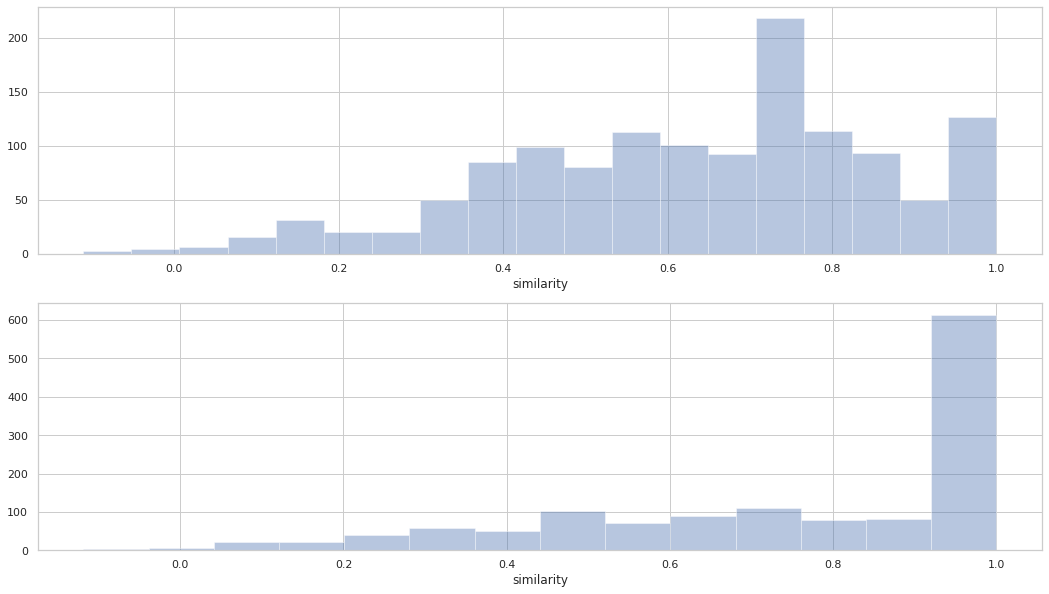

In [4]:
# Subset the data (remove metadata)
vars_to_keep = ['adj_positiveness', 'np_positiveness', 'np']
with_sim_raw = df[vars_to_keep + ['response']]
# with lemmatized response
with_sim_lemma = df[vars_to_keep + ['lemma']]


# Add similarity ratings
with_sim_raw = append_similarity(with_sim_raw, sim_df).dropna()
with_sim_lemma = append_similarity(with_sim_lemma, sim_df, y = 'lemma').dropna()


# Plot with/without hue
# plot shows similarity distributions over all response - np pairs
sns.set(style = 'whitegrid')

fig, axs = plt.subplots(nrows = 2)
fig.set_size_inches(18, 10)

# the first one is on raw data
sns.distplot(with_sim_raw["similarity"], ax = axs[0], kde = False)

# the second one is on preprocessed data
sns.distplot(with_sim_lemma["similarity"], ax = axs[1], kde = False)

plt.show()

## Add identity evaluation of NP and response (pattern-matching)

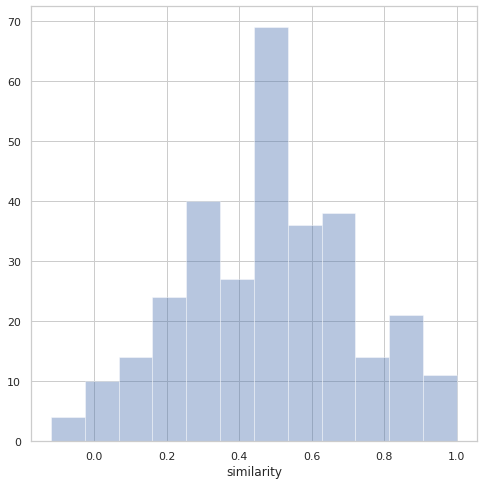

In [5]:
# add column indicating identical nps and responses based on simple pattern-matching
# --------------------------------------------------------------------------------------
# NB: it collapses pairs pretty liberally, if the response occurs in the NP and vice versa they are count as identical
# ---------------------------------------------------------------------------------------
with_sim_lemma['is_resp_identical'] = with_sim_lemma.apply(lambda s: True if (s['lemma'] in s['np']) or (s['np'] in s['lemma']) else False, axis=1)
 
# unique non-identical nps and responses 
non_identical_resp = with_sim_lemma[with_sim_lemma['is_resp_identical'] == False ].drop_duplicates()
identical_resp = with_sim_lemma[with_sim_lemma['is_resp_identical'] == True ].drop_duplicates()
# non_identical_resp

# add similarities
non_identical_resp = append_similarity(non_identical_resp, sim_df, y = 'lemma').dropna()
identical_resp = append_similarity(identical_resp, sim_df, y = 'lemma').dropna()

# plot similarity distributions of only non-identical np-response pairs 

sns.set(style = 'whitegrid')

fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(8, 8)

sns.distplot(non_identical_resp["similarity"], ax = ax1, kde = False)

plt.show()

In [6]:
# look if any identical responses were not categorized as such
with_sim_lemma[with_sim_lemma['is_resp_identical'] == False].sort_values(['similarity'])

,adj_positiveness,np_positiveness,np,lemma,similarity,is_resp_identical
1093,negative,neither-nor,eel,wait,-0.118549,False
371,negative,negative,hummingbird,day outside,-0.0731167,False
898,positive,positive,giraffe,the others,-0.0695456,False
1026,positive,negative,hummingbird,sound in the area,-0.0504282,False
1284,negative,positive,rooster,day outside,-0.013917,False
219,positive,negative,hummingbird,noise around there,-0.0066811,False
832,negative,neither-nor,parrot,place,0.00127528,False
113,positive,positive,rooster,sound near by,0.00710513,False
775,negative,positive,rooster,place or town,0.00804429,False
284,negative,positive,rooster,time of day,0.0220474,False


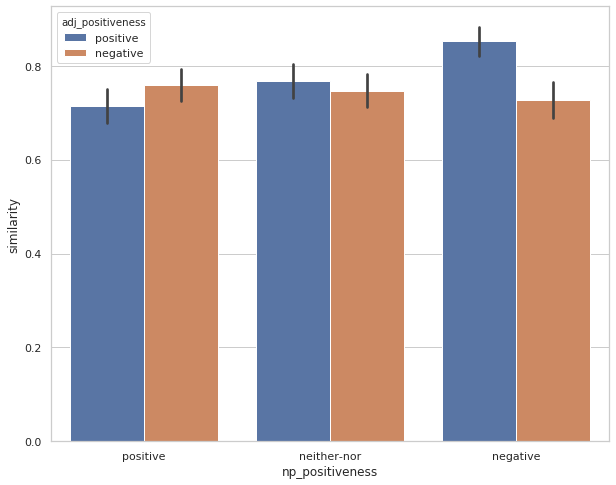

In [7]:
# average similarity of the entire data based on the np group, by adjective condition 
sns.set(style = 'whitegrid')

fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(10, 8)

sns.barplot(x="np_positiveness", y="similarity", hue="adj_positiveness", data= with_sim_lemma, ax = ax1)


plt.show()

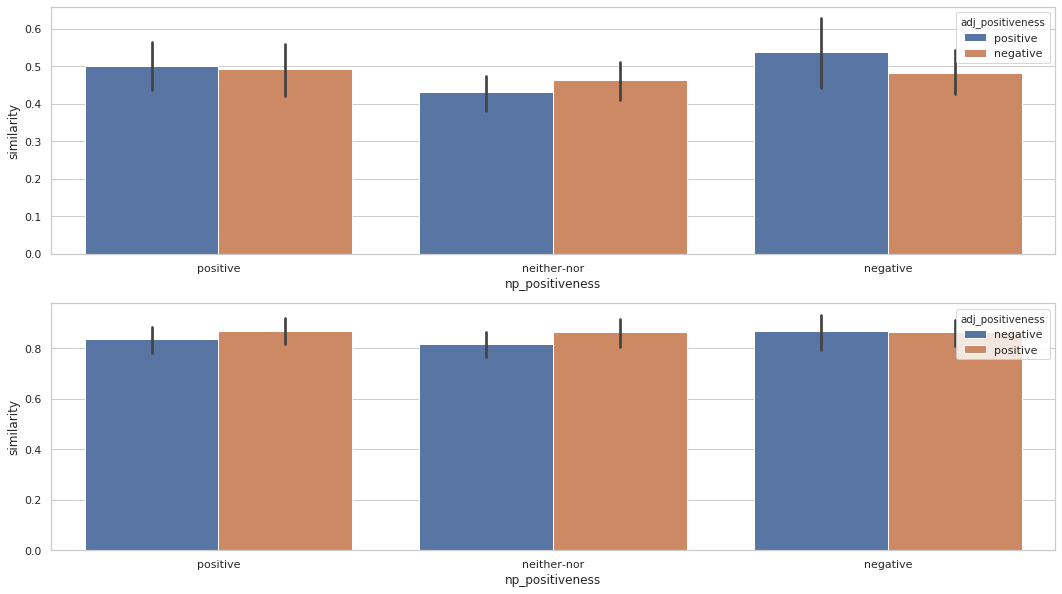

In [9]:
# average similarity of responses/NPs separated into identical and non-identical based on np positiveness, by adjective condition
# identity based on pattern matching

sns.set(style = 'whitegrid')

fig, axs = plt.subplots(nrows = 2)
fig.set_size_inches(18, 10)

# non-identical responses
sns.barplot(x="np_positiveness", y="similarity", hue="adj_positiveness", data=non_identical_resp, ax = axs[0])
# identical responses, not too much varince to be expected since these pairs are very similar  
sns.barplot(x="np_positiveness", y="similarity", hue="adj_positiveness", order=['positive', 'neither-nor', 'negative'], data=identical_resp, ax = axs[1])

plt.show()

# similarity of non-identical pairs around 0.5, similarity of identical pairs around 0.8

In [10]:
# number of identity judgements, to be compared with similarity-based judgements 
with_sim_lemma['is_resp_identical'].value_counts()

True     862
False    491
Name: is_resp_identical, dtype: int64

## Average similarities in the single items, grouped by NP positiveness and adjective positiveness

/home/jmadeano/Desktop/comparison-class/analysis/helpers.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['similarity'] = embedding.apply(lambda row: np.dot(row[x], row[y]), axis = 1)
/home/jmadeano/Desktop/comparison-class/analysis/helpers.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['similarity'] = data['similarity'][is_scalar]
/home/jmadeano/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:720: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  wa

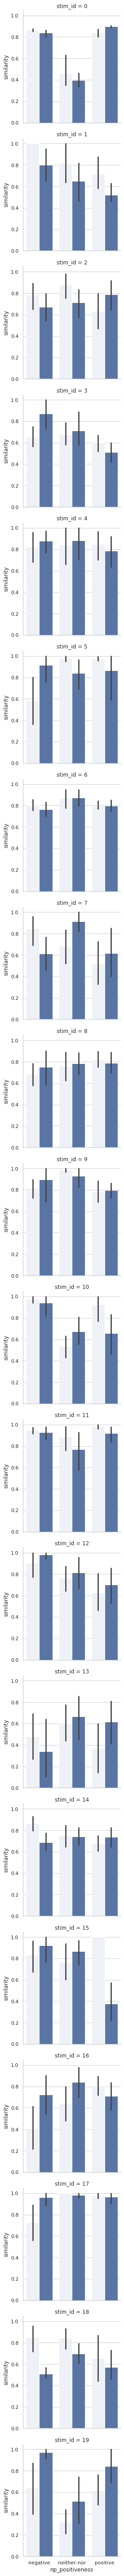

In [11]:
# average similarity of responses and NPs based on np positiveness, by adjective condition
# identity based on pattern matching

vars_to_keep = ['adj_positiveness', 'np_positiveness', 'np', 'lemma', 'stim_id']
with_sim_dim = df[vars_to_keep]

with_sim_dim = append_similarity(with_sim_dim, sim_df, y = 'lemma').dropna()

# ordered_ids = with_sim_dim['stim_id'].value_counts().index

pic = sns.FacetGrid(with_sim_dim, row = "stim_id",  height=4)
pic.map(sns.barplot, "np_positiveness", "similarity", "adj_positiveness", order=["negative", "neither-nor", "positive"])



# Average Similarity Based on Positiveness

/home/jmadeano/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


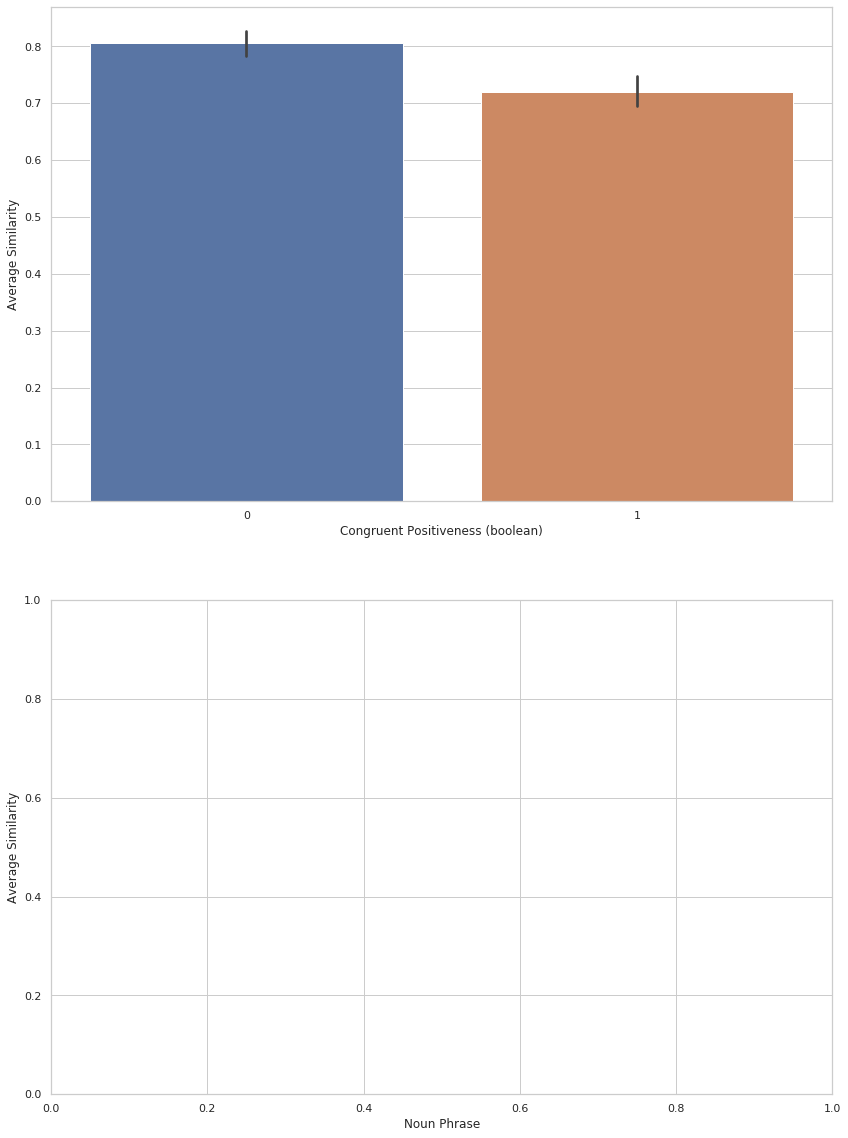

In [12]:
# Remove neither-nor examples
congruent_positiveness = with_sim_lemma[with_sim_lemma['np_positiveness'] != 'neither-nor']

# Create combined positiveness -> True if np_positiveness == adj_positive
# it is identical to the plots above collapsed by 'congruence' (positive - positive / negative - negative being congruent) 
congruent_positiveness['combined_positiveness'] = congruent_positiveness.apply(lambda row: 1 if row['adj_positiveness'] == row['np_positiveness'] else 0, axis = 1)

congruent_positiveness = congruent_positiveness.drop(columns = ['np_positiveness', 'adj_positiveness'])


# DEPRECATED: subsetting by NPs just takes the nps which occured most as an experimental condition 
# Sort and subset the 10 most common NPs
# most_common_nps = congruent_positiveness['np'].value_counts().index.tolist()[:10]
# congruent_positiveness = congruent_positiveness[congruent_positiveness['np'].isin(most_common_nps)]


# Plot with/without hue
sns.set(style = 'whitegrid')

fig, axs = plt.subplots(nrows = 2)
fig.set_size_inches(14, 20)

# 
sns.barplot(x="combined_positiveness", y="similarity", data = congruent_positiveness, ax = axs[0])
# deprecated, similar to above facet plot
# sns.barplot(y="np", x="similarity", hue = "combined_positiveness", data = congruent_positiveness, ax = axs[1])

axs[0].set(ylabel='Average Similarity', xlabel = 'Congruent Positiveness (boolean)')
axs[1].set(ylabel='Average Similarity', xlabel = 'Noun Phrase')

plt.show()


## Average item simialrity in congruent trials

In [13]:
# group items (NPs) by positiveness, ignoring control neither-nor ones 
by_np_positiveness = with_sim_lemma[with_sim_lemma['np_positiveness'] != 'neither-nor']
by_np_positiveness['combined_positiveness'] = by_np_positiveness.apply(lambda row: 1 if row['adj_positiveness'] == row['np_positiveness'] else 0, axis = 1)

# extrcat the congruent trials
by_np_positiveness = by_np_positiveness[by_np_positiveness['combined_positiveness'] == 1]


# by_np_positiveness, sort nps according to increasing average similarity
positive_nps = by_np_positiveness[by_np_positiveness['np_positiveness'] == 'positive'].groupby(['np'])['similarity'].aggregate(np.mean).reset_index().sort_values('similarity')
negative_nps = by_np_positiveness[by_np_positiveness['np_positiveness'] == 'negative'].groupby(['np'])['similarity'].aggregate(np.mean).reset_index().sort_values('similarity')

# plot positive and negative items separatly, colored by congruence condition (combined_positiveness = 1 is congruent)

sns.set(style = 'whitegrid')

fig, axs = plt.subplots(nrows = 2)
fig.set_size_inches(14, 20)

# 
sns.barplot(x="similarity", y="np", order = positive_nps['np'], data = positive_nps, ax = axs[0])
sns.barplot(y="np", x="similarity", order = negative_nps['np'], data = negative_nps, ax = axs[1])

axs[0].set(ylabel='Positive Noun Phrases', xlabel = 'Average Similarity')
axs[1].set(ylabel='Negative Noun Phrases', xlabel = 'Average Similarity')

plt.show()


/home/jmadeano/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


DataError: No numeric types to aggregate

In [ ]:
# DEPRECATED: same plots as above grouping by np and adjective positiveness but non-comprehensive
# positiveness = with_sim_lemma

# positiveness['positiveness'] = positiveness.apply(lambda row: (row['adj_positiveness'], row['np_positiveness']), axis = 1)


# # Plot with/without hue
# sns.set(style = 'whitegrid')

# fig, axs = plt.subplots(1,1)
# fig.set_size_inches(14, 10)

# sns.barplot(y="positiveness", x="similarity", data = positiveness, ax = axs)

# # axs[0].set(ylabel='Average Similarity', xlabel = 'Congruent Positiveness (boolean)')
# axs.set(ylabel='Average Similarity', xlabel = 'Noun Phrase')

# plt.show()    

## Identity Analysis Based on Similarity

In [ ]:
with_identity = with_sim_lemma

# this cutoff-value is set manually

# the results are different from the pattern-matching based classification by the order of about 250 responses being classified as different ones 

with_identity['is_identical'] = with_identity['similarity'].apply(lambda sim: sim >= .97)

with_identity['is_identical'].value_counts()


In [ ]:
# Subset the 10 most common NPs
# subset = with_identity.drop_duplicates()['np'].tolist()[:10]
# with_identity = with_identity[with_identity['np'].isin(subset)]


with_identity['count'] = with_identity.groupby(['np']).transform('count').iloc[:, 0]
with_identity['identical'] = with_identity.groupby(['np'])['is_identical'].transform('sum')
with_identity['different'] = with_identity['count'] - with_identity['identical']


same_diff = with_identity[['np', 'identical', 'different']].drop_duplicates()
same_diff = pd.melt(same_diff, id_vars = ['np'], var_name = 'same')

# plot the counts of different vs identical responses per NP ()item

# Plot with/without hue
sns.set(style = 'whitegrid')

fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(18, 10)

ax = sns.barplot(x = 'value', y = 'np', hue = 'same', data = same_diff, ax = ax1)

plt.show()

In [ ]:
# look at subordinate (identical) vs not responses by congruence condition
with_identity['combined_positiveness'] = with_identity.apply(lambda row: 1 if row['adj_positiveness'] == row['np_positiveness'] else 0, axis = 1)

with_identity['count'] = with_identity.groupby(['np']).transform('count').iloc[:, 0]
with_identity['identical'] = with_identity.groupby(['np'])['is_identical'].transform('sum')
with_identity['different'] = with_identity['count'] - with_identity['identical']


# same_diff = with_identity[['np', 'identical', 'different', 'np_positiveness', 'similarity']].drop_duplicates()
# same_diff = pd.melt(same_diff, id_vars = ['np'], var_name = 'same')


# Plot with/without hue
sns.set(style = 'whitegrid')

fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(8, 6)

ax = sns.barplot(x = 'combined_positiveness', y = 'is_identical', data = with_identity, ax = ax1)
# ax = sns.distplot(with_identity['np_positiveness'], hue = 'is_identical')

plt.show()

In [ ]:
# Subset the data (remove metadata)
vars_to_keep = ['adj_positiveness', 'np_positiveness', 'np', 'lemma', 'stim_id']
with_sim_by_dim = df[vars_to_keep]


# Add similarity ratings
with_sim_by_dim = append_similarity(with_sim_by_dim, sim_df, y = 'lemma').dropna()


# Plot with/without hue
sns.set(style = 'whitegrid')

fig, axs = plt.subplots(1,1)
fig.set_size_inches(14, 10)

sns.barplot(x="stim_id", y="similarity", data = with_sim_by_dim, ax = axs, ci = 'sd')

# axs[0].set(ylabel='Average Similarity', xlabel = 'Congruent Positiveness (boolean)')
axs.set(ylabel='Average Similarity', xlabel = 'Stim ID/Dimension')

plt.show()

In [ ]:
#  deprecated: average similarity by np positiveness in several items 
# dims_with_subsets = with_sim_by_dim[['np', 'stim_id', 'similarity', 'np_positiveness']]


# # Sort and subset the 5 most common NPs
# most_common_dims = dims_with_subsets['stim_id'].value_counts().index.tolist()[:10]
# dims_with_subsets = dims_with_subsets[dims_with_subsets['stim_id'].isin(most_common_dims)]


# dims_with_subsets.sort_values(['stim_id', 'np_positiveness'])
# # dims_with_subsets = pd.melt(dims_with_subsets, id_vars = ['stim_id'], var_name = 'same')


# # Plot with/without hue
# sns.set(style = 'whitegrid')

# fig, axs = plt.subplots(1,1)
# fig.set_size_inches(25, 10)


# sns.barplot(x = "stim_id", y = "similarity", hue = 'np_positiveness', data = dims_with_subsets, ax = axs, 
#             ci = 'sd', orient = 'v')

# # axs[0].set(ylabel='Average Similarity', xlabel = 'Congruent Positiveness (boolean)')
# axs.set(ylabel='Average Similarity', xlabel = 'Stim ID/Dimension')

# plt.show()

## Sort responses into novel and identical to NP/superordinate (preprocessing for prior estimation)

In [ ]:
# Sort and subset the 10 most common lemmas (responses)
most_common_lemmas = with_sim_lemma['lemma'].value_counts().index.tolist()[:-60]
most_common_lemmas
# congruent_positiveness = congruent_positiveness[congruent_positiveness['np'].isin(most_common_nps)]

# right now the pattern based identity judgements are based on resp or np being part of other
# it might be helpful to have a generic word / bootstrap per np to be sure
# there might be dificult cases > is box of wine and wine different nps of same dimension? 
# manual processing and consideration required

# it might be possible to group be this pattern matching and then process further based on similarity / clusters in similarity 
# try replace potentially problematic nps:
# the morning / the evening -> morning, evening
#  gymnasium -> gym
# piece of furniture / clothing -> furniture / cloth
# TV show -> show

df_mod = df[['np_positiveness', 'adj_positiveness', 'np', 'lemma', 'superordinate']]
df_mod['superordinate'] = df_mod['superordinate'].apply(lambda s: lemmatizer.lemmatize(s)) 
df_mod = append_similarity(df_mod, sim_df, y = 'lemma').dropna()
df_mod['np'] = df_mod['np'].apply(lambda x: x.replace('the morning', 'morning'))
df_mod['np'] = df_mod['np'].apply(lambda x: x.replace('the evening', 'evening'))
df_mod['np'] = df_mod['np'].apply(lambda x: x.replace('gymnasium', 'gym'))
df_mod['np'] = df_mod['np'].apply(lambda x: x.replace('piece of furniture', 'furniture'))
df_mod['np'] = df_mod['np'].apply(lambda x: x.replace('piece of clothing', 'cloth'))
df_mod['np'] = df_mod['np'].apply(lambda x: x.replace('tv show', 'show'))

# here, identical means being in the np or the superordinate, to filter out 'novel' responses 
df_mod['is_resp_identical'] = df_mod.apply(lambda s: True if (s['lemma'] in s['np']) or (s['np'] in s['lemma']) or (s['superordinate'] in s['lemma']) else False, axis=1)
df_mod['is_resp_identical'].value_counts()

In [ ]:
# manually processed, there are only the roughly 60 new responses below 

df_mod[df_mod['is_resp_identical']==False].sort_values(['similarity'])
novel_responses = df_mod[df_mod['is_resp_identical']==False].drop_duplicates(['lemma'])
novel_responses.sort_values(['np', 'similarity'])

# responses_for_priors = ['friend', 'people', 'men', 'human', 'place', 'thing', 'baseball player', 'alcohol', 'beverage', 'liquor', 
#                        'price', 'package', 'wine', 'product', 'meat', 'guy', 'kid', 'shirt', 'item', 
#                        'drink', 'duration', 'video', 'pet', 'noise', 'music', 'player', 'musical instrument',
#                        'drummer', 'day', 'sealife', 'animal in zoo', 'animal', 'fish', 'mail', 'time',
#                        'night', 'time of year', 'weather', 'food', 'meal', 'object', 'event', 'sound', 
#                        'dessert', 'child', 'room', 'ape', 'light', 'hour', 'time of day', 'bird', 'concert', 
#                        'machine', '']
# print(novel_responses.sort_values(['np', 'similarity']).to_string())